In [2]:
import numpy as np
from scipy.optimize import minimize

np.seterr(divide='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [147]:
def distance(x, xp, weights):
    median = np.median(x)
    abs_diff = np.abs(x - xp) * weights
    mad = np.median(np.abs(x - median))
    if mad == 0:
        mad = 1e-9
    d = np.sum(abs_diff / mad)
    return d

def loss_function(x, xp, yp, balance, predict, weights=None):
    if weights is None:
        weights = np.ones(x.shape)
    return balance((predict(xp) - yp) ** 2) + distance(x, xp, weights)



In [137]:
def model(x):
    # xor
    return np.abs(x[0] - x[1])
print(model([0, 0]))
print(model([1, 0]))
print(model([0, 1]))
print(model([0.8, 0.2]))

0
1
1
0.6000000000000001


In [22]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
data = datasets.load_breast_cancer()

In [116]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)
model = GaussianNB()
model.fit(x_train, y_train)

res = model.predict(x_test)
print(r2_score(y_test, res))

0.623015873015873


In [27]:
print(data.target_names)

['malignant' 'benign']


In [209]:
i = 3
# input vector
# input_example = x_test[y_test == 1][i]
input_example = np.array([0, 1])
desired_output = 0

balance = 0.001
# maximum diff with desired output
epsilon = 0.01
# step size for increasing desired output importance in loss
alpha = 10

weights = np.ones(input_example.shape)
# weights = np.array([1, 10])
# weights[[1, 5, 8]] = 2
# weights[[0, 10, 15]] = .5
# predict = lambda x:model.predict([x])[0]
predict = model

# initial counterfactual
xp = np.random.random_sample(input_example.shape)
print(input_example, xp)
# optimize loss
def loss(xp):
    return loss_function(input_example, xp, desired_output, lambda x: balance * x, predict, weights)
res = minimize(loss, xp)
# print(res)
xp = res.x

print("Initial input", input_example)
print("Initial prediction", predict(input_example))
print("Prediction objective", desired_output)
print("Counterfactual", xp)
print("Prediction made using counterfactual", predict(xp))
print("Diff with initial input", xp - input_example)

[0 1] [0.41856143 0.08829357]
Initial input [0 1]
Initial prediction 1
Prediction objective 0
Counterfactual [-7.17951449e-04  9.99999995e-01]
Prediction made using counterfactual 1.0007179465496485
Diff with initial input [-7.17951449e-04 -4.89890428e-09]


In [210]:
i = 0
while np.abs(predict(xp) - desired_output) > epsilon:
    xp = np.random.random_sample(input_example.shape)
    balance *= alpha
    print(balance, predict(xp))
    # print(xp)
    def loss(xp):
        return loss_function(input_example, xp, desired_output, lambda x: balance * x, predict, weights)
    res = minimize(loss, xp)
    xp = res.x
    i += 1

print("Step ", i)
print("Initial input", input_example)
print("Initial prediction", predict(input_example))
print("Prediction objective", desired_output)
print("Counterfactual", xp)
print("Prediction made using counterfactual", predict(xp))
print("Diff with initial input", xp - input_example)

0.01 0.7646153043666034
0.1 0.17380676848878018
1.0 0.4275962980807253
10.0 0.7598343076593457
100.0 0.4924739941061401
1000.0 0.08599449122295655
Step  6
Initial input [0 1]
Initial prediction 1
Prediction objective 0
Counterfactual [0.99621483 1.        ]
Prediction made using counterfactual 0.0037851688287607876
Diff with initial input [ 9.96214827e-01 -3.86195675e-09]


In [211]:
def loss(xp):
    return loss_function(input_example, xp, desired_output, lambda x: 1000 * x, predict, weights)
for i in range(10):
    xp = np.random.random_sample(input_example.shape)
    res = minimize(loss, xp)
    xp = res.x
    print(res.x, predict(res.x))


[0.99899998 0.99999999] 0.0010000074439092677
[0.99468385 0.99999999] 0.00531614060187624
[0.99451167 0.99999999] 0.005488323280531726
[0.99899998 0.99999999] 0.0010000074440709161
[0.99463243 0.99999999] 0.005367563238761086
[0.99324506 1.        ] 0.00675493801493654
[0.99899998 0.99999999] 0.001000007422734761
[0.99899998 0.99999999] 0.0010000074581459906
[0.99899998 0.99999999] 0.0010000074673981452
[0.99454824 0.99999999] 0.005451750887793039


<BarContainer object of 2 artists>

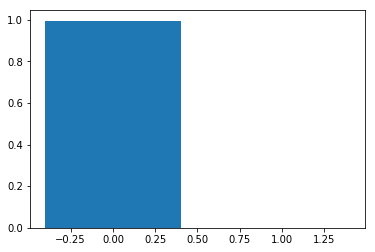

In [212]:
%matplotlib inline
import matplotlib.pyplot as plt
rel_diff = (xp - input_example)
plt.bar(list(range(len(xp))), rel_diff)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f